### Membuat pola spasial tingkat kesejahteraan Kabupaten Probolinggo
<p style="text-align: justify;">Notebook ini mendemonstrasikan pemetaan pola spasial tingkat kesejahteraan Rumah Tangga di Kabupaten Probolinggo yang dihasilkan dari dataset RWI menggunakan Python. Kita akan menggunakan pandas untuk manipulasi data, geopandas untuk operasi spasial, matplotlib untuk plotting, dan contextily untuk menambahkan peta dasar.<br>

**Tentang Dataset RWI dari META** <br>
Relative Wealth Index (RWI) adalah dataset yang dikembangkan oleh META (sebelumnya Facebook) bekerja sama dengan Center for International Earth Science Information Network (CIESIN) di Columbia University. Dataset ini menyediakan estimasi tingkat kesejahteraan (wealth) relatif untuk area geografis kecil di seluruh dunia, termasuk Indonesia.<br>
Beberapa poin penting tentang dataset RWI:

1. Metodologi: RWI dihasilkan menggunakan kombinasi dari citra satelit beresolusi tinggi, data survei, dan machine learning.
2. Skala: Data tersedia pada resolusi grid 2.4km x 2.4km, memberikan gambaran detail tentang variasi tingkat kesejahteraan (wealth) suatu wilayah.
3. Interpretasi: Nilai RWI berkisar dari 0 hingga 100, di mana nilai yang lebih tinggi menunjukkan tingkat kekayaan relatif yang lebih tinggi.
4. Kegunaan: Dataset ini sangat berguna untuk berbagai aplikasi, salah satunya untuk memberikan dimensi spasial terhadap tingkat kesejahteraan suatu wilayah.

<br>Dalam analisis ini, kita akan menggunakan dataset RWI dalam memetakan tingkat kesejahteraan Rumah Tangga (RT) untuk mendapatkan wawasan tentang pola spasial kesejahteraan ekonomi di wilayah Kabupaten Probolinggo.

**Mengimpor Pustaka yang Diperlukan** 
<br>Pustaka-pustaka ini penting untuk analisis kita:

- pandas: Untuk manipulasi dan analisis data
- geopandas: Untuk bekerja dengan data geospasial
- matplotlib.pyplot: Untuk membuat plot dan visualisasi
- contextily: Untuk menambahkan peta dasar ke plot kita
- Kita menambahkan os untuk menangani operasi sistem file, yang akan digunakan saat membaca file geojson kecamatan.

In [57]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import os

**Membuat fungsi Batas Plot**
<br>Fungsi ini membantu mengatur batas plot dengan menambahkan sedikit padding di sekitar area geografis yang menjadi fokus.<br>

In [58]:
def set_plot_bounds(ax, gdf, padding=0.1):
    bounds = gdf.total_bounds
    width = bounds[2] - bounds[0]
    height = bounds[3] - bounds[1]
    ax.set_xlim(bounds[0] - width * padding, bounds[2] + width * padding)
    ax.set_ylim(bounds[1] - height * padding, bounds[3] + height * padding)

**Memuat dan Menyiapkan Data**
<br>Di sini, kita melakukan dua hal utama:

1. Memuat data RWI dari file CSV dan mengubahnya menjadi GeoDataFrame dengan geometri titik.
2. Memuat data batas administratif Kabupaten Probolinggo beserta wilayah Kecamatan didalamnya dari file GeoJSON.

In [88]:
# Memuat data RWI
df = pd.read_csv(r'E:\Project\GH\spasialRWI\data\idn_relative_wealth_index.csv')
gdf_points = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# Memuat data batas administratif Probolinggo
gdf_probolinggo = gpd.read_file(r'E:\Project\GH\spasialRWI\data\geojson\35.13.geojson')

# Memuat data kecamatan
kecamatan_folder = r'E:\Project\GH\spasialRWI\data\geojson\kecamatan'
gdf_kecamatan = gpd.GeoDataFrame()

for filename in os.listdir(kecamatan_folder):
    if filename.endswith('.geojson'):
        file_path = os.path.join(kecamatan_folder, filename)
        gdf_temp = gpd.read_file(file_path)
        gdf_kecamatan = pd.concat([gdf_kecamatan, gdf_temp], ignore_index=True)

# Memuat data desa
desa_folder = r'E:\Project\GH\spasialRWI\data\geojson\desa'
gdf_desa = gpd.GeoDataFrame()

for filename in os.listdir(desa_folder):
    if filename.endswith('.geojson'):
        file_path = os.path.join(desa_folder, filename)
        gdf_temp = gpd.read_file(file_path)
        gdf_desa = pd.concat([gdf_desa, gdf_temp], ignore_index=True)

print(f"Jumlah kecamatan yang dimuat: {len(gdf_kecamatan)}")
print(f"Jumlah kecamatan yang dimuat: {len(gdf_desa)}")

Jumlah kecamatan yang dimuat: 24
Jumlah kecamatan yang dimuat: 330


**Memproyeksikan Ulang Data**
<br>Kita memproyeksikan ulang kedua dataset ke EPSG:3857 (proyeksi Web Mercator). <br>
Hal ini penting untuk operasi spasial dan visualisasi yang akurat.

In [60]:
# Memproyeksikan ulang data ke sistem koordinat yang sesuai (Web Mercator)
gdf_points = gdf_points.to_crs(epsg=3857)
gdf_probolinggo = gdf_probolinggo.to_crs(epsg=3857)
gdf_kecamatan = gdf_kecamatan.to_crs(epsg=3857)
gdf_desa = gdf_desa.to_crs(epsg=3857)

print(f"CRS data points: {gdf_points.crs}")
print(f"CRS data Probolinggo: {gdf_probolinggo.crs}")
print(f"CRS data kecamatan: {gdf_kecamatan.crs}")
print(f"CRS data desa: {gdf_desa.crs}")

CRS data points: EPSG:3857
CRS data Probolinggo: EPSG:3857
CRS data kecamatan: EPSG:3857
CRS data desa: EPSG:3857


**Penggabungan Spasial**
<br>Operasi ini melakukan penggabungan spasial untuk menyaring hanya titik-titik RWI yang berada dalam batas Probolinggo.<br>

In [61]:
# Penggabungan spasial untuk mendapatkan nilai RWI pada peta Probolinggo
gdf_points_in_probolinggo = gpd.sjoin(gdf_points, gdf_probolinggo, how="inner", predicate="within")

**Membuat Peta**
<br>Bagian ini membuat peta akhir:

1. Menyiapkan plot dengan ukuran yang ditentukan.
2. MMenekankan batas administratif.
3. Memplot titik-titik RWI, diwarnai berdasarkan nilai RWI-nya.
4. Mengatur batas plot menggunakan fungsi pembantu kita.
5. Menambahkan judul dan label.
6. Menambahkan peta dasar OpenStreetMap untuk konteks.

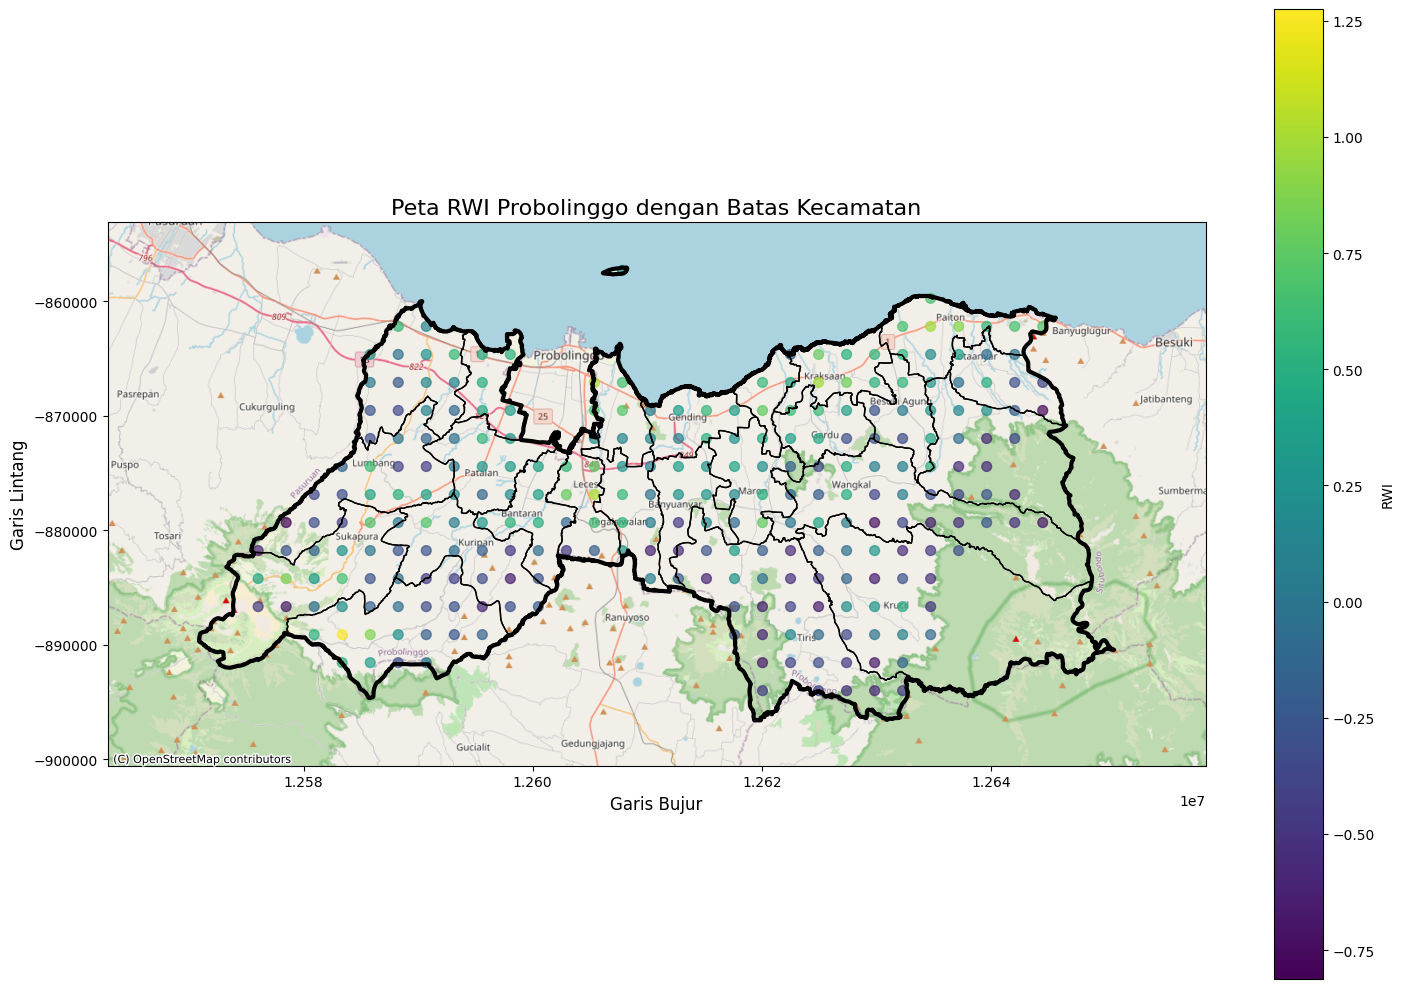

In [85]:
# Plot peta RWI Probolinggo dengan batas kecamatan
fig, ax = plt.subplots(figsize=(15, 10))

# Plot batas Probolinggo
gdf_probolinggo.plot(ax=ax, color='none', edgecolor='black', linewidth=2)

# Plot batas kecamatan
gdf_kecamatan.boundary.plot(ax=ax, color='black', linewidth=1)

# Plot batas desa
#gdf_desa.boundary.plot(ax=ax, color='blue', linewidth=1, linestyle='--')

# Plot titik-titik RWI
scatter = gdf_points_in_probolinggo.plot(ax=ax, column='rwi', cmap='viridis', 
                                         legend=True, legend_kwds={'label': 'RWI'},
                                         markersize=50, alpha=0.7)

# Mengatur batas plot
set_plot_bounds(ax, gdf_probolinggo, padding=0.1)

# Menambahkan judul dan label
plt.title('Peta RWI Probolinggo dengan Batas Kecamatan', fontsize=16)
plt.xlabel('Garis Bujur', fontsize=12)
plt.ylabel('Garis Lintang', fontsize=12)

# Menambahkan peta dasar
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=11)

# Menekankan batas Probolinggo
gdf_probolinggo.boundary.plot(ax=ax, color='black', linewidth=3)

plt.tight_layout()
plt.show()

Titik-titik pada peta merepresentasikan lokasi data RWI yang tersedia.
Karakteristik titik RWI yang mencakup luasan 2,4 KM. Titik-titik RWI tidak mencover seluruh wilayah. Pada peta tampak bahwa sisi tenggara tidak terdapat titik RWI karena wilayah tersebut merupakan kawasan hutan yang tidak memiliki populasi.

Statistik RWI Per Kecamatan

In [68]:
# Menghitung statistik Tingkat Kesejahteraan per kecamatan
gdf_points_in_probolinggo = gdf_points_in_probolinggo.rename(columns={'index_right': 'index_right_old'})
gdf_kecamatan = gdf_kecamatan.rename(columns={'name': 'WADMKC'})
gdf_rwi_kecamatan = gpd.sjoin(gdf_points_in_probolinggo, gdf_kecamatan, how="inner")
rwi_stats = gdf_rwi_kecamatan.groupby('WADMKC')['rwi'].agg(['mean', 'median', 'std']).reset_index()
rwi_stats = rwi_stats.sort_values('mean', ascending=False)

print("Statistik Tingkat Kesejahteraan per Kecamatan:")
print(rwi_stats)


Statistik Tingkat Kesejahteraan per Kecamatan:
          WADMKC      mean  median       std
16     Pejarakan  0.598000  0.5850  0.163887
14        Paiton  0.583100  0.6635  0.304345
7       Kraksaan  0.566429  0.5360  0.376855
3         Dringu  0.564500  0.6775  0.350984
11         Leces  0.413750  0.6005  0.522123
19    Sumberasih  0.404143  0.4530  0.121261
8      Krejengan  0.335833  0.3950  0.337056
5        Gending  0.320667  0.3375  0.209898
13         Maron  0.276444  0.2530  0.305674
0       Bantaran  0.203000  0.3285  0.309782
23     Wonomerto  0.168571  0.1740  0.246407
20  Tegalsiwalan  0.148111  0.0990  0.358564
1     Banyuanyar  0.139833  0.2590  0.306094
2          Besuk  0.088571  0.0580  0.395533
22        Tongas  0.058786  0.0680  0.306398
18        Sumber  0.054444 -0.1065  0.504248
17      Sukapura  0.045063 -0.0245  0.447539
6      Kotaanyar -0.099857 -0.0690  0.447538
12       Lumbang -0.114125 -0.2130  0.416816
10       Kuripan -0.133000 -0.2030  0.355250
9       

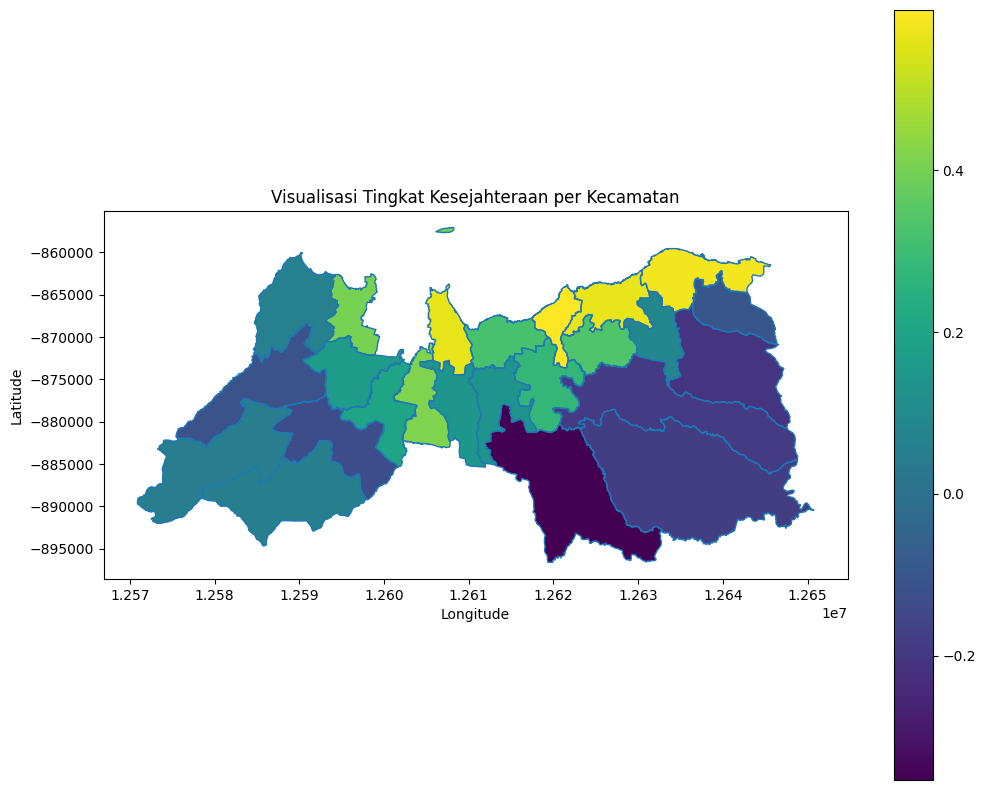

In [74]:
# Gabungkan GeoDataFrame dengan DataFrame RWI
gdf_kec_visual = gdf_kecamatan.merge(rwi_stats, on='WADMKC', how='left')

# Buat choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_kec_visual.boundary.plot(ax=ax, linewidth=1)
gdf_kec_visual.plot(column='mean', ax=ax, legend=True,
                   cmap='viridis', 
                   missing_kwds={"color": "lightgrey", "label": "Missing values"})

# Tambahkan judul
plt.title('Visualisasi Tingkat Kesejahteraan per Kecamatan')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Tampilkan peta
plt.show()

Peta menggunakan skala warna 'viridis', yang menunjukkan nilai RWI (Relative Wealth Index) dengan warna dari biru (nilai RWI rendah) hingga kuning (nilai RWI tinggi). Semakin terang warna suatu area, semakin tinggi nilai RWI di daerah tersebut.

Statistik RWI Per Desa <br>
Untuk mengidentifikasi pola dan tren yang lebih rinci, selanjutnya kita hitung nilai RWI hingga skala Desa.

In [76]:
# Menghitung statistik Tingkat Kesejahteraan per desa
gdf_points_in_probolinggo = gdf_points_in_probolinggo.rename(columns={'index_right': 'index_right_old'})
gdf_desa = gdf_desa.rename(columns={'name': 'WADMDS'})
gdf_rwi_desa = gpd.sjoin(gdf_points_in_probolinggo, gdf_desa, how="inner")
rwi_stats_desa = gdf_rwi_desa.groupby('WADMDS')['rwi'].agg(['mean', 'median', 'std']).reset_index()
rwi_stats_desa = rwi_stats_desa.sort_values('mean', ascending=False)

print("Statistik Tingkat Kesejahteraan per Desa:")
print(rwi_stats_desa)

Statistik Tingkat Kesejahteraan per Desa:
             WADMDS   mean  median       std
141      Sumberanom  1.077   1.077  0.280014
148  Sumberkedawung  1.037   1.037       NaN
55         Kalirejo  1.025   1.025       NaN
26             Bulu  0.987   0.987       NaN
93           Paiton  0.886   0.886       NaN
..              ...    ...     ...       ...
17             Bimo -0.587  -0.587       NaN
15      Betek Taman -0.607  -0.607  0.076368
44         Guyangan -0.658  -0.658       NaN
89        Ngadirejo -0.675  -0.675       NaN
157      Tambakukir -0.773  -0.773       NaN

[184 rows x 4 columns]


<p style="text-align: justify;">Perhitungan statistik per Desa menghasilkan jumlah 184 data dari seharusnya sejumlah 330 data (jumlah Desa & Kelurahan di Kabupaten Probolinggo).
Hal ini disebabkan karena data RWI memiliki resolusi seluas 2,4 KM. Karakteristik cakupan area ini menunjukkan bahwa data RWI mewakili titik-titik dengan jarak tertentu, bukan mencakup seluruh wilayah secara kontinu.
Beberapa wilayah administratif Desa mungkin tidak memiliki titik RWI di dalamnya, terutama jika wilayah tersebut kecil atau memiliki bentuk yang tidak teratur (kompleks).<br>
Keterbatasan ini dapat ditindaklanjuti dengan beberapa pendekatan:<br>
1. Agregasi: Menghitung rata-rata atau statistik lain dari nilai RWI untuk setiap wilayah administratif.<br>
2. Interpolasi: Menggunakan metode interpolasi spasial untuk memperkirakan nilai RWI di area yang tidak memiliki data.<br>
3. Nearest Neighbor: Menggunakan metode nearest neighbor untuk mengisi nilai wilayah yang tidak memiliki data berdasarkan titik RWI terdekat.<br>

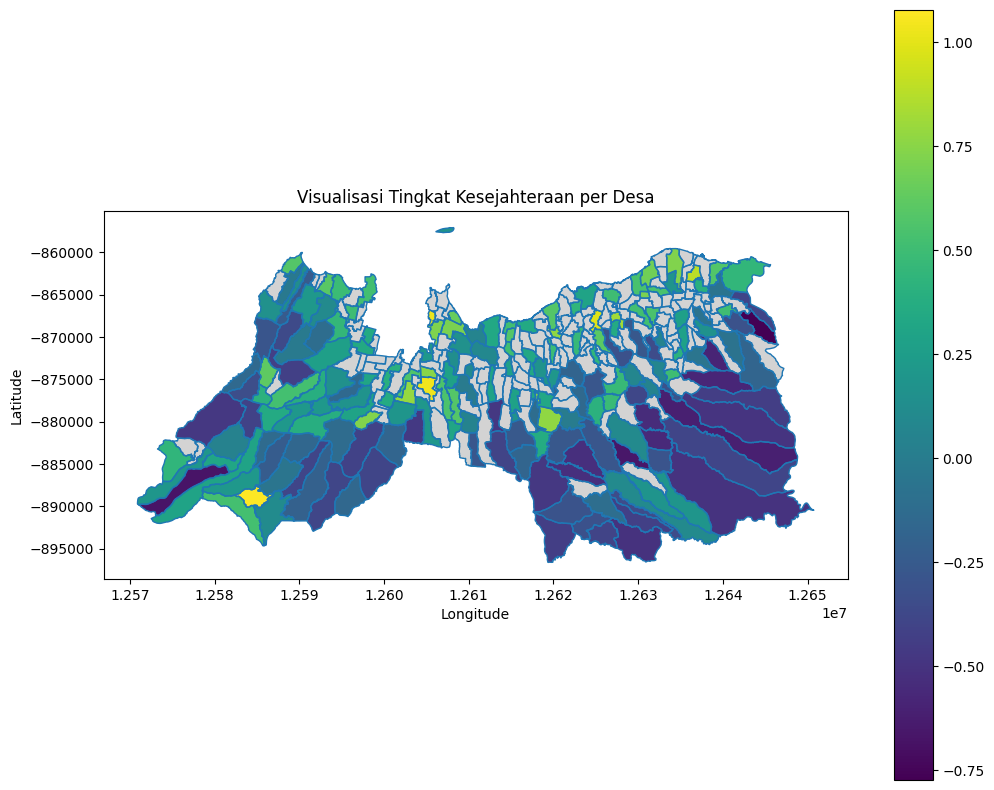

In [75]:
# Gabungkan GeoDataFrame dengan DataFrame RWI
gdf_desa_visual = gdf_desa.merge(rwi_stats_desa, on='WADMDS', how='left')

# Buat choropleth map
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_desa_visual.boundary.plot(ax=ax, linewidth=1)
gdf_desa_visual.plot(column='mean', ax=ax, legend=True,
                   cmap='viridis', 
                   missing_kwds={"color": "lightgrey", "label": "Missing values"})

# Tambahkan judul
plt.title('Visualisasi Tingkat Kesejahteraan per Desa')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Tampilkan peta
plt.show()

Dari visualisasi statistik per Desa tampak bahwa data RWI dengan karakteristik area 2,4 km mungkin terlalu kasar untuk menangkap variasi di tingkat desa, terutama untuk desa-desa yang lebih kecil. Hal ini berbeda dengan visualisasi statistik RWI pada tingkat Kecamatan yang dapat mencover seluruh area administratif. Kecamatan, sebagai unit administratif yang lebih besar, memiliki kemungkinan lebih tinggi untuk mencakup setidaknya satu titik RWI. Sebaliknya, desa-desa yang lebih kecil mungkin "terlewatkan" oleh grid RWI 2,4 km.

**SELANJUTNYA (eksplorasi lanjutan)**
- Tambahan visualisasi Statistik dan Data
- Menggabungkan High Resolution Population Density Maps versi Indonesia dari META
- Menambahkan label nama kecamatan pada peta
- Penggunaan teknik analisis spasial lanjutan, seperti analisis klaster atau deteksi hotspot, untuk mengidentifikasi area dengan nilai RWI yang serupa atau berbeda secara signifikan.
- Data tambahan yang mungkin terkait dengan distribusi RWI, seperti data demografi, ekonomi, atau infrastruktur.Analisis korelasi antara variabel-variabel ini dengan nilai RWI untuk menemukan pola dan wawasan yang lebih dalam.

